In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import connection

In [38]:
conn = connection()

In [39]:
df_t_pulse = pd.read_sql("SELECT * FROM t_pulse_data LIMIT 1000", conn)

In [40]:
df_t_pulse

,id,ticker,inserted,text,commentsCount,reactionCount,reactions_counters
0,8f32cf94-e800-40ef-bbc8-02da1fd7c602,RUAL,2020-12-24,​​\n🇩🇪🇺🇸 {$AAPL} {$TSLA}\nГенеральный директор...,3,14,"[{'type': 'like', 'count': 11}, {'type': 'buy-..."
1,03e1031d-6d5b-4390-b5b3-a0443acc4bdb,RUAL,2020-12-24,​​В четверг 24 декабря рынок открывается вблиз...,11,215,"[{'type': 'like', 'count': 215}]"
2,a0a6ce40-0bae-4240-8c31-b20860709677,RUAL,2020-12-24,{$BABA} {$TCS} {$AMEZ} {$RUAL} {$SPCE} {$SPLK}...,26,12,"[{'type': 'like', 'count': 11}, {'type': 'rock..."
3,d943ab99-0c35-4aa8-8092-7fbd5db85d0a,RUAL,2020-12-24,ON FLEEK TIMES [219] от 21.12.2020.\n▪️- Здрас...,29,528,"[{'type': 'like', 'count': 522}, {'type': 'buy..."
4,e0650186-cedb-434d-8c26-be55c385ca0d,RUAL,2020-12-24,"☝️Член комитета по делам банков, жилищного стр...",2,0,[]
...,...,...,...,...,...,...,...
995,445f0c4e-d122-4a2c-ae29-58f649264939,RUAL,2020-04-03,{$RUAL} ПОДПИШЕТ С GLENCORE КОНТРАКТ ПО ПРОД...,1,0,[]
996,40574944-1834-4f02-ba6f-9df63b177b1f,RUAL,2020-04-02,{$RUAL} {$GMKN} 💥РУСАЛ ОТКЛОНИЛ ИДЕЮ ИНТЕРРОСА...,2,5,"[{'type': 'like', 'count': 5}]"
997,35365fa5-6d2f-4e81-bd78-5dcabb87e017,RUAL,2020-04-02,{$RUAL} расти моя русалочка,0,1,"[{'type': 'like', 'count': 1}]"
998,5fa4210f-8419-496b-ac6a-7114f3fe70e9,RUAL,2020-04-01,{$RUAL} А что с дивами у них?,0,2,"[{'type': 'like', 'count': 2}]"


In [34]:
df_t_pulse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  1000 non-null   object        
 1   ticker              1000 non-null   object        
 2   inserted            1000 non-null   datetime64[ns]
 3   text                1000 non-null   object        
 4   commentsCount       1000 non-null   int64         
 5   reactionCount       1000 non-null   int64         
 6   reactions_counters  1000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 54.8+ KB


In [41]:
tickers_info = pd.read_sql("""
    SELECT ticker, COUNT(*) as post_count
    FROM t_pulse_data 
    GROUP BY ticker 
    ORDER BY post_count DESC
""", conn)

In [45]:
weekly_stats = pd.read_sql("""
    SELECT 
        DATE_TRUNC('week', inserted) as week_start,
        COUNT(*) as total_posts,
        COUNT(DISTINCT ticker) as unique_tickers
    FROM t_pulse_data 
    GROUP BY week_start
    ORDER BY week_start
""", conn)

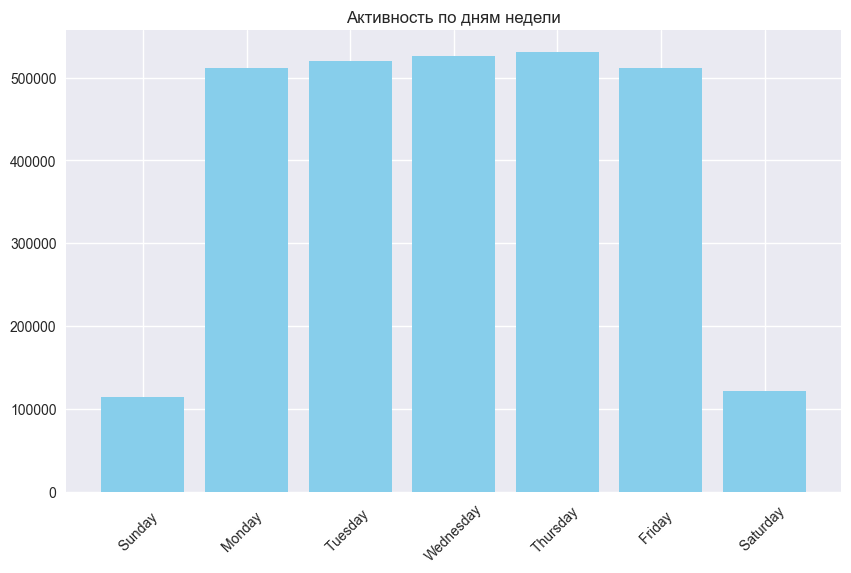

In [62]:
daily_pattern = pd.read_sql("""
    SELECT 
        EXTRACT(DOW FROM inserted) as day_of_week,
        TO_CHAR(inserted, 'Day') as day_name,
        COUNT(*) as post_count
    FROM t_pulse_data 
    GROUP BY day_of_week, day_name
    ORDER BY day_of_week
""", conn)

plt.figure(figsize=(10, 6))
plt.bar(daily_pattern['day_name'], daily_pattern['post_count'], color='skyblue')
plt.title('Активность по дням недели')
plt.xticks(rotation=45)
plt.show()

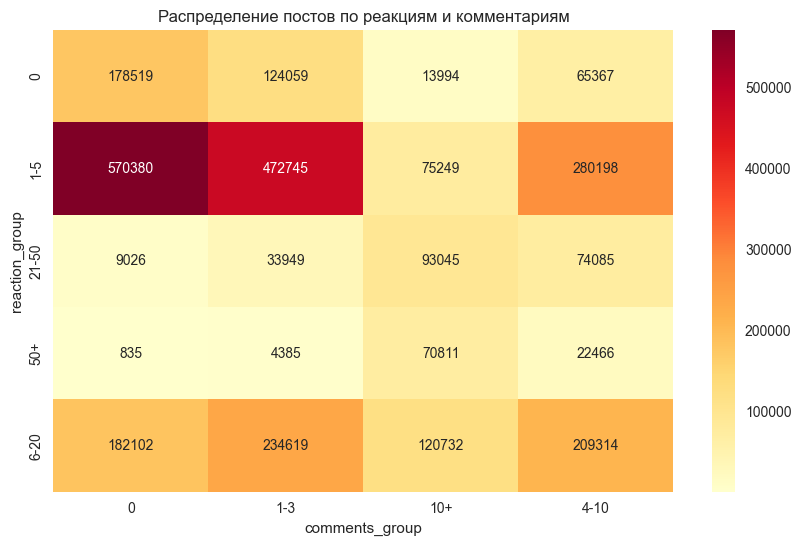

In [67]:
engagement_stats = pd.read_sql("""
    SELECT 
        CASE 
            WHEN "reactionCount" = 0 THEN '0'
            WHEN "reactionCount" BETWEEN 1 AND 5 THEN '1-5'
            WHEN "reactionCount" BETWEEN 6 AND 20 THEN '6-20'
            WHEN "reactionCount" BETWEEN 21 AND 50 THEN '21-50'
            ELSE '50+'
        END as reaction_group,
        CASE 
            WHEN "commentsCount" = 0 THEN '0'
            WHEN "commentsCount" BETWEEN 1 AND 3 THEN '1-3'
            WHEN "commentsCount" BETWEEN 4 AND 10 THEN '4-10'
            ELSE '10+'
        END as comments_group,
        COUNT(*) as post_count
    FROM t_pulse_data 
    GROUP BY reaction_group, comments_group
    ORDER BY reaction_group, comments_group
""", conn)

pivot_engagement = engagement_stats.pivot(index='reaction_group', columns='comments_group', values='post_count')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_engagement, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Распределение постов по реакциям и комментариям')
plt.show()

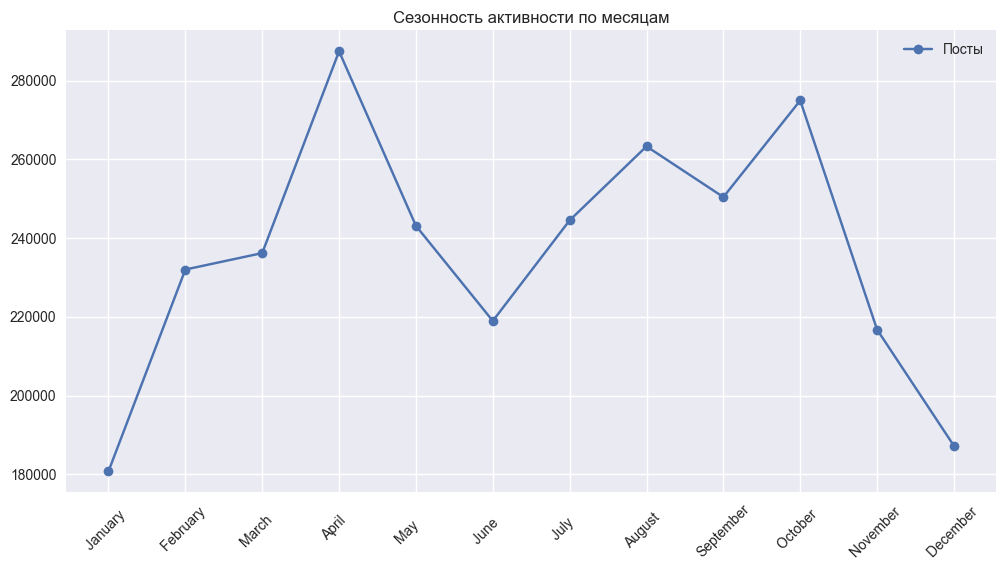

In [72]:
monthly_pattern = pd.read_sql("""
    SELECT 
        EXTRACT(MONTH FROM inserted) as month,
        TO_CHAR(inserted, 'Month') as month_name,
        COUNT(*) as post_count
    FROM t_pulse_data 
    GROUP BY month, month_name
    ORDER BY month
""", conn)

plt.figure(figsize=(12, 6))
plt.plot(monthly_pattern['month_name'], monthly_pattern['post_count'], marker='o', label='Посты')
plt.title('Сезонность активности по месяцам')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [46]:
weekly_stats

,week_start,total_posts,unique_tickers
0,2019-08-26,2,2
1,2019-09-02,53,17
2,2019-09-09,176,39
3,2019-09-16,441,42
4,2019-09-23,669,44
...,...,...,...
318,2025-09-29,19772,81
319,2025-10-06,18159,81
320,2025-10-13,16244,81
321,2025-10-20,15695,80


In [49]:
weekly_stats['week_start'].min()

Timestamp('2019-08-26 00:00:00')

In [50]:
weekly_stats['week_start'].max()

Timestamp('2025-10-27 00:00:00')

In [51]:
len(weekly_stats)

323

In [53]:
int(weekly_stats['total_posts'].max())

27208

In [55]:
int(weekly_stats['total_posts'].mean())

8779

In [56]:
int(weekly_stats['total_posts'].median())

5422

In [57]:
int(weekly_stats['unique_tickers'].max())

81

In [32]:
tickers_info

,ticker,post_count
0,T,194523
1,GAZP,189283
2,VTBR,131445
3,MTLR,113406
4,SBER,100291
...,...,...
76,CNRU,2002
77,FIXR,1936
78,IRAO,1774
79,RASP,1511


In [9]:
tickers_info.describe()

,post_count
count,81.000000
mean,35010.864198
std,37835.003737
min,1367.000000
25%,8859.000000
50%,22911.000000
75%,50452.000000
max,194523.000000


In [21]:
tickers_info.ticker.unique()

array(['T', 'GAZP', 'VTBR', 'MTLR', 'SBER', 'EUTR', 'SGZH', 'PLZL',
       'GMKN', 'SPBE', 'ALRS', 'RNFT', 'CHMF', 'PIKK', 'MTSS', 'AFKS',
       'WUSH', 'NLMK', 'MAGN', 'POSI', 'RUAL', 'LKOH', 'SNGSP', 'ROSN',
       'SOFL', 'SFIN', 'UGLD', 'SELG', 'TRMK', 'NMTP', 'UPRO', 'MVID',
       'SBERP', 'RTKM', 'ASTR', 'IRKT', 'HYDR', 'VKCO', 'SVCB', 'LSRG',
       'TATN', 'AQUA', 'SVAV', 'NVTK', 'FEES', 'SMLT', 'AFLT', 'ENPG',
       'MOEX', 'MGNT', 'SIBN', 'RENI', 'OGKB', 'RTKMP', 'YDEX', 'PHOR',
       'HEAD', 'LEAS', 'CBOM', 'AKRN', 'BSPB', 'TTLK', 'LENT', 'SNGS',
       'VSMO', 'FLOT', 'X5', 'BELU', 'MRKP', 'OZPH', 'TATNP', 'IVAT',
       'MRKC', 'RAGR', 'MDMG', 'UWGN', 'CNRU', 'FIXR', 'IRAO', 'RASP',
       'VSEH'], dtype=object)

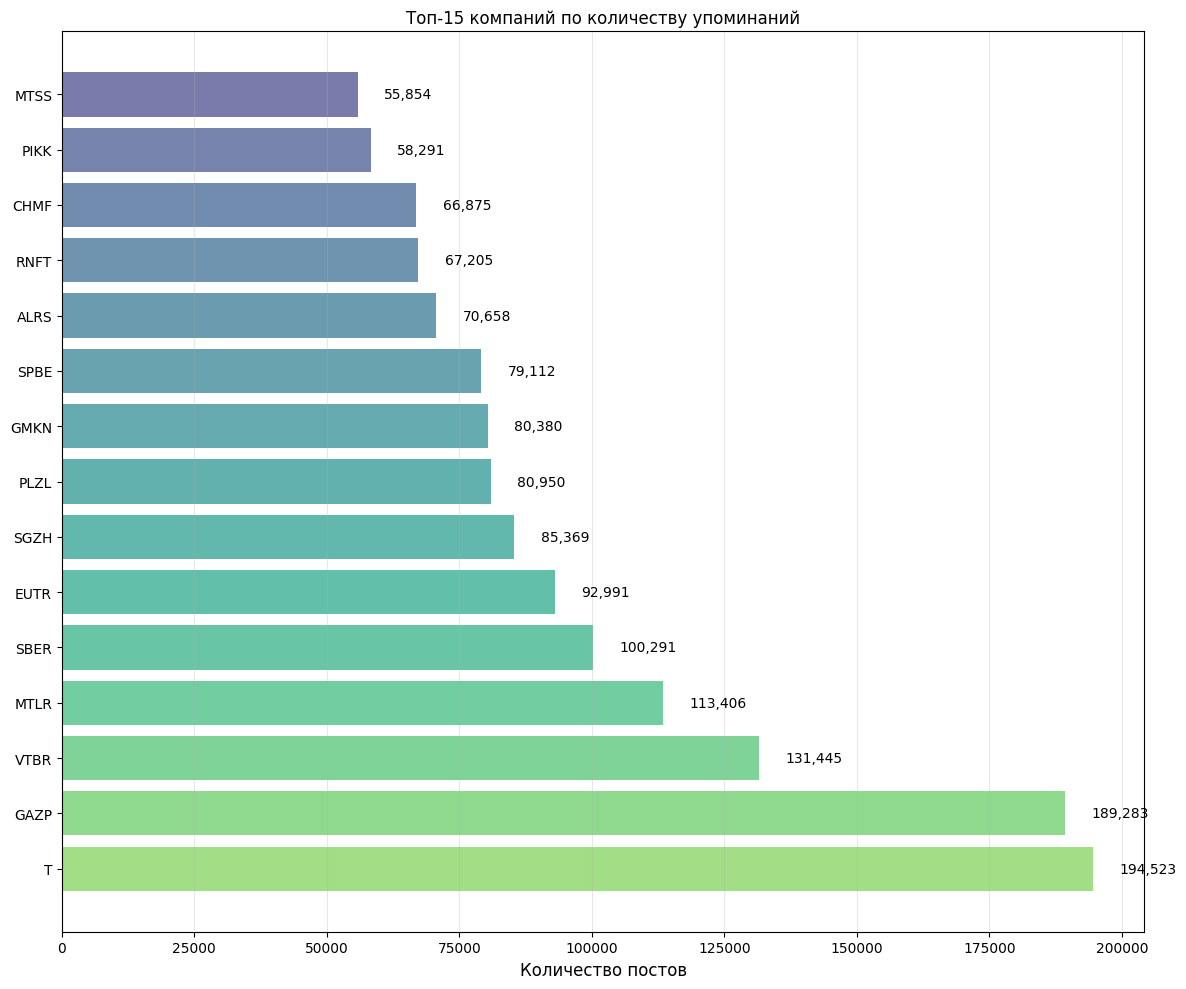

In [22]:
plt.figure(figsize=(12, 10))
top_15 = tickers_info.head(15)

colors = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(top_15)))

bars = plt.barh(top_15['ticker'], top_15['post_count'], color=colors, alpha=0.7)

plt.xlabel('Количество постов', fontsize=12)
plt.title('Топ-15 компаний по количеству упоминаний')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5000, bar.get_y() + bar.get_height()/2, 
             f'{width:,}', ha='left', va='center', fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

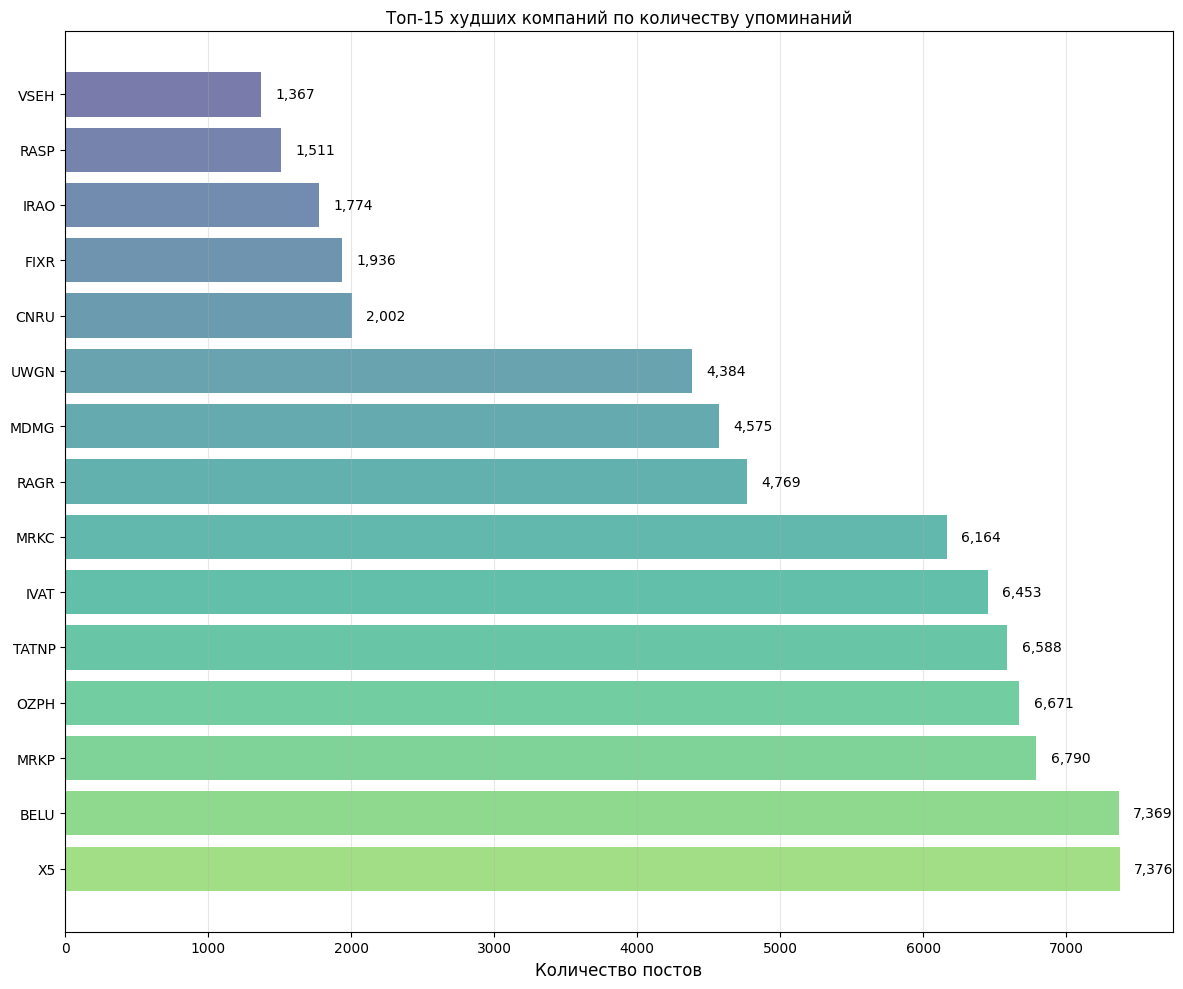

In [27]:
plt.figure(figsize=(12, 10))
top_15 = tickers_info.tail(15)

colors = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(top_15)))

bars = plt.barh(top_15['ticker'], top_15['post_count'], color=colors, alpha=0.7)

plt.xlabel('Количество постов', fontsize=12)
plt.title('Топ-15 худших компаний по количеству упоминаний')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2, 
             f'{width:,}', ha='left', va='center', fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

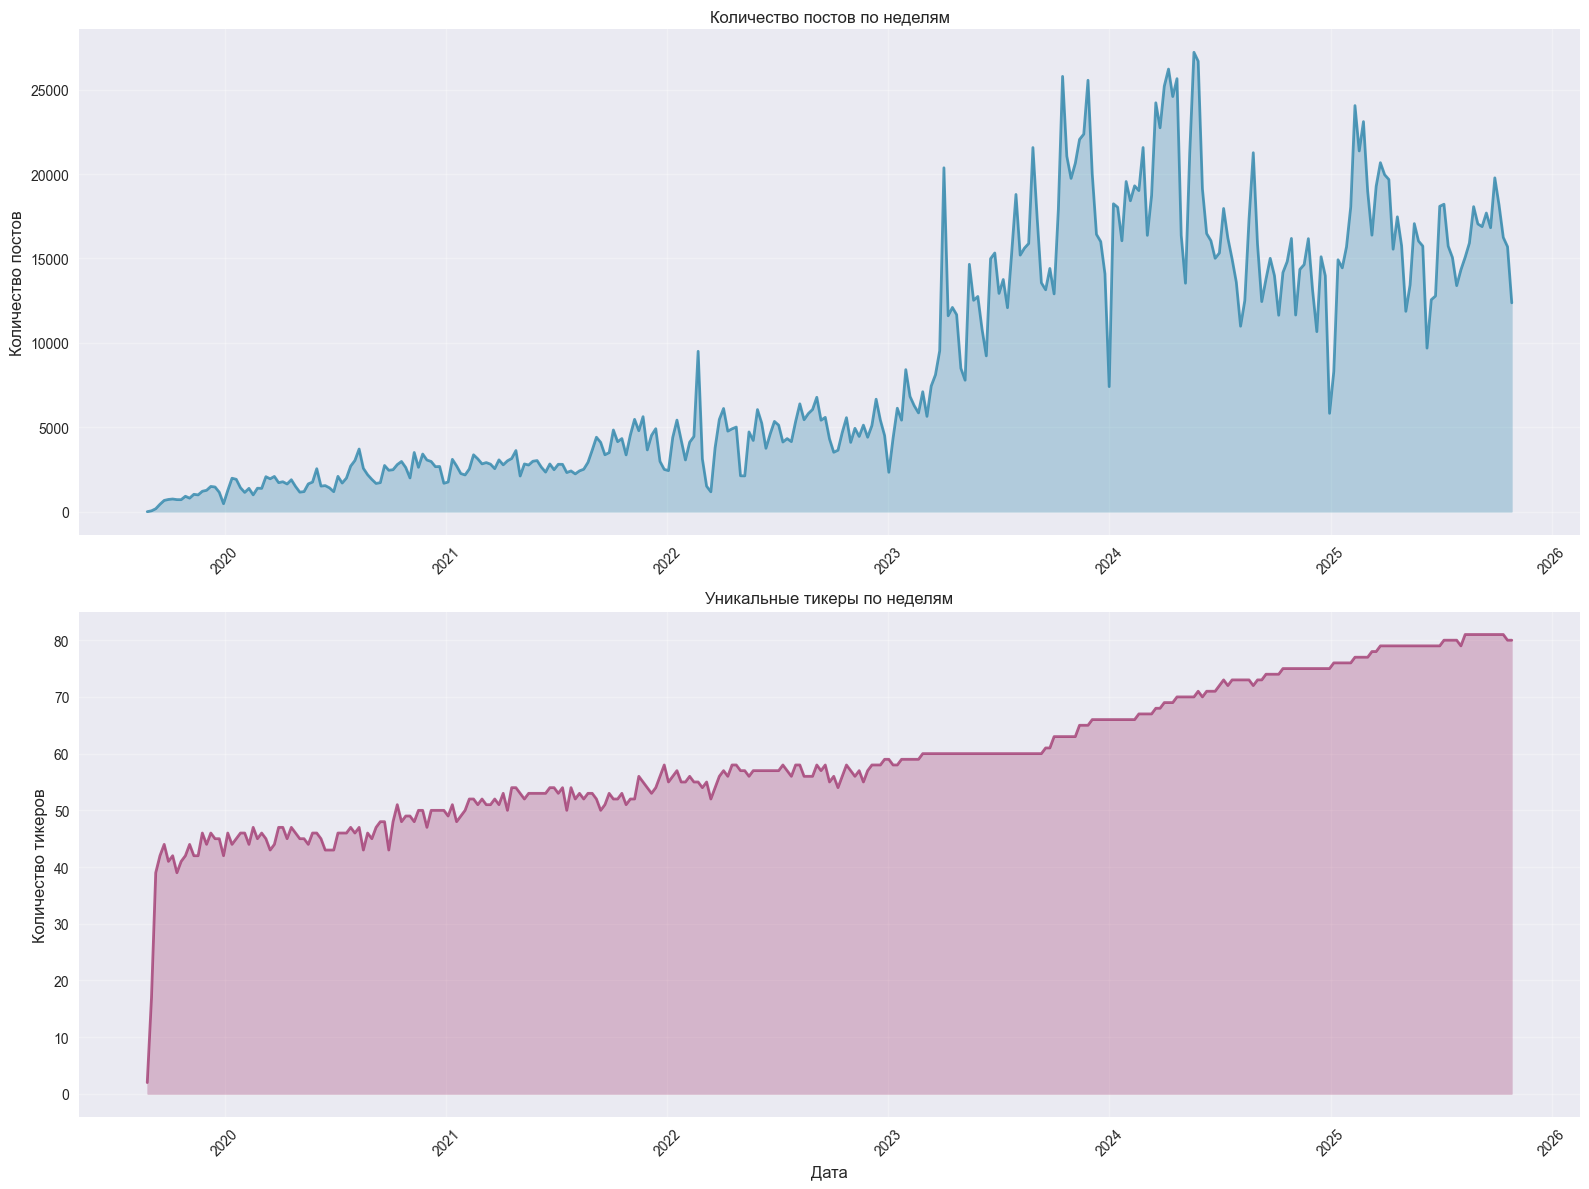

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].plot(weekly_stats['week_start'], weekly_stats['total_posts'], 
             linewidth=2, color='#2E86AB', alpha=0.8)
axes[0].fill_between(weekly_stats['week_start'], weekly_stats['total_posts'], 
                    alpha=0.3, color='#2E86AB')
axes[0].set_title('Количество постов по неделям')
axes[0].set_ylabel('Количество постов', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(weekly_stats['week_start'], weekly_stats['unique_tickers'], 
             linewidth=2, color='#A23B72', alpha=0.8)
axes[1].fill_between(weekly_stats['week_start'], weekly_stats['unique_tickers'], 
                    alpha=0.3, color='#A23B72')
axes[1].set_title('Уникальные тикеры по неделям')
axes[1].set_ylabel('Количество тикеров', fontsize=12)
axes[1].set_xlabel('Дата', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

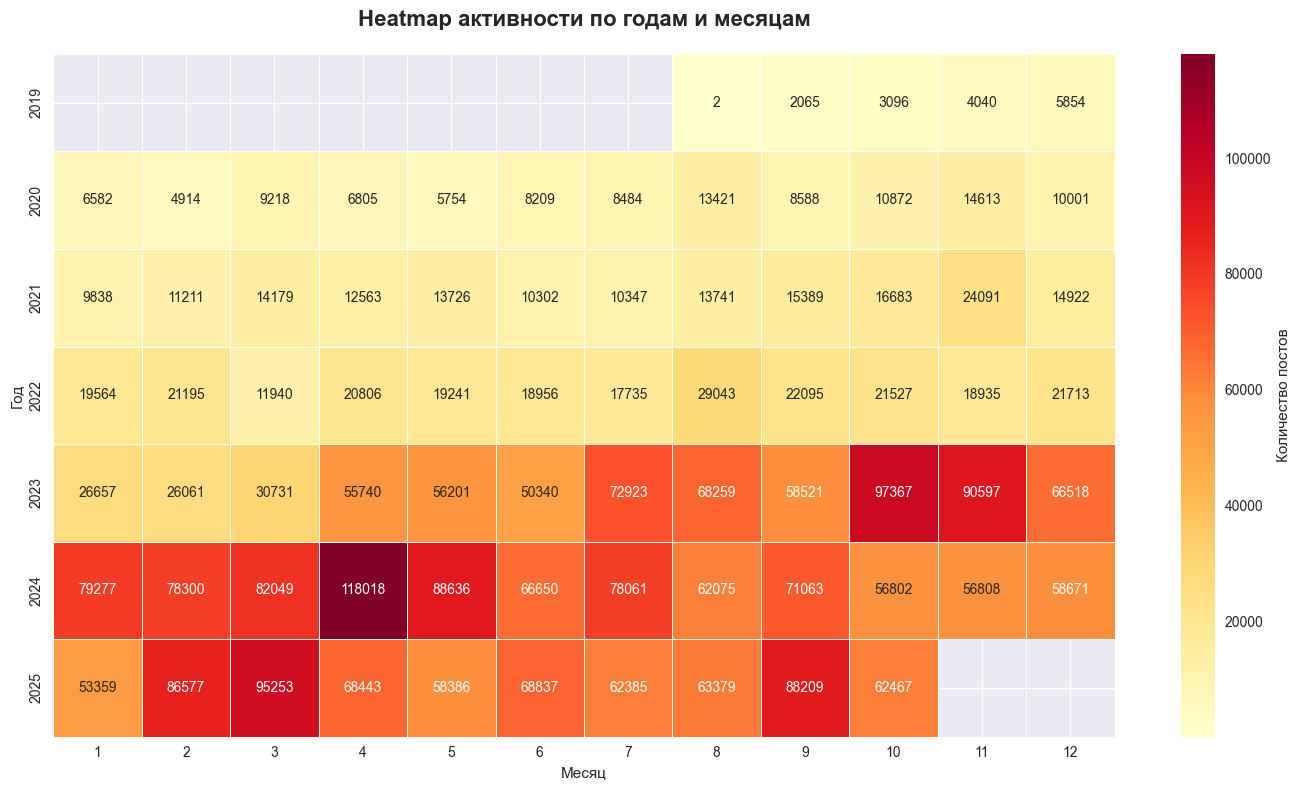

In [61]:
weekly_stats['year'] = weekly_stats['week_start'].dt.year
weekly_stats['month'] = weekly_stats['week_start'].dt.month

monthly_heatmap = weekly_stats.groupby(['year', 'month'])['total_posts'].sum().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(monthly_heatmap, annot=True, fmt='.0f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Количество постов'})
plt.title('Heatmap активности по годам и месяцам', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Год')
plt.tight_layout()
plt.show()